# 1. 필요한 module import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

from tqdm import tqdm

%matplotlib inline

batch_size = 16
learning_rate = 1e-3
epochs = 1

## CIFAR10 dataset download

- 이름에서 알 수 있듯이 10개의 class가 있다.

In [2]:
cifar_train = dsets.CIFAR10(root="CIFAR10/",
                            train=True,
                            transform=transforms.Compose([
                                # data augmentation
                                transforms.Scale(36),
                                transforms.CenterCrop(32),
                                # transforms.RandomHorizontalFlip(),
                                # transforms.Lambda(lambda x: x.rotate(90)),
                                # data normalization
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                            ]),
                            target_transform=None,
                            download=True)

cifar_test  = dsets.CIFAR10(root="CIFAR10/",
                          train=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                          ]),
                          target_transform=None,
                          download=True)

C:\Users\USER\anaconda3\envs\vonenet\lib\site-packages\torchvision\transforms\transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Files already downloaded and verified
Files already downloaded and verified


# 2. 대략적인 데이터 형태

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이 : 50000
cifar_test  길이 : 10000
image data 형태 : torch.Size([3, 32, 32])
label           : 9
[[[-0.02745098  0.03529418  0.10588241 ... -0.31764704 -0.3098039
   -0.372549  ]
  [-0.02745098  0.02745104  0.11372554 ... -0.2862745  -0.34117645
   -0.41960782]
  [ 0.03529418  0.16078436  0.34901965 ... -0.3098039  -0.3960784
   -0.4352941 ]
  ...
  [-0.23921567 -0.38039213 -0.3490196  ... -0.6156863  -0.5686275
   -0.3098039 ]
  [ 0.05882359  0.00392163  0.01176476 ... -0.6392157  -0.67058825
   -0.4980392 ]
  [ 0.22352946  0.16078436  0.09803927 ... -0.69411767 -0.6313726
   -0.4980392 ]]

 [[-0.01176471  0.05882359  0.17647064 ... -0.29411763 -0.2862745
   -0.3490196 ]
  [-0.01176471  0.03529418  0.16078436 ... -0.26274508 -0.31764704
   -0.3960784 ]
  [ 0.05098045  0.16078436  0.36470592 ... -0.2862745  -0.372549
   -0.41960782]
  ...
  [-0.23137254 -0.38039213 -0.38039213 ... -0.654902   -0.5764706
   -0.29411763]
  [ 0.082353    0.02745104 -0.00392157 ... -0.6862745  -0.

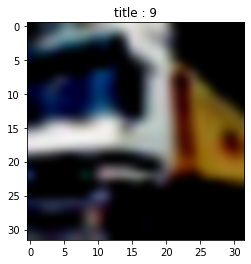

In [3]:
print(f'cifar_train 길이 : {len(cifar_train)}')
print(f'cifar_test  길이 : {len(cifar_test)}')

# 데이터 하나의 형태
img, label = cifar_train.__getitem__(1)
print(f'image data 형태 : {img.shape}')
print(f'label           : {label}')

# 그리기
img = img.numpy()
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]

img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title(f'title : {label}')
print(img)
plt.imshow(img2, interpolation='bicubic')
plt.show()

## accuracy 계산 함수

In [4]:
def compute_acc(dloader=None, model=None):
    model.eval()

    correct = 0
    total = 0

    for i, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs, requires_grad=False).cuda()
        label = Variable(labels).cuda()

        output = model(img)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print(f'Accuracy of Test Data: {100 * correct/total}')

# 3. dataloader

In [5]:
train_loader = DataLoader(dataset=cifar_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=6,
                          drop_last=True)
test_loader  = DataLoader(dataset=cifar_test,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=6,
                          drop_last=True)

# 4. model 선언

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 100),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)

    def forward(self, x):
        x = self.layer(x)
        x = self.fc_layer(x)

        return x

def training():
    model = CNN().cuda()
    model.train()

    for epoch in range(epochs):
        model = model.train()

        for img, label in tqdm(train_loader):
            x = Variable(img).cuda()
            y = Variable(label).cuda()

            optimizer.zero_grad()

            output = model.forward(x)
            loss = loss_fn(output, y)

            loss.backward()
            optimizer.step()

        print(f'epoch: {epoch:3d}  loss: {loss:4f}')

    compute_acc(test_loader, model=model)



# 5. loss, optimizer

In [7]:
model = CNN().cuda()
model.train()

loss_fn = nn.CrossEntropyLoss().cuda()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# (6) Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# (7) learning rate decay
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

<ipython-input-6-dc71b180c9df>:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-6-dc71b180c9df>:38: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


KeyboardInterrupt: 

# 6. train

In [ ]:

for epoch in range(epochs):
    for img, label in tqdm(train_loader):
        x = Variable(img).cuda()
        y = Variable(label).cuda()

        optimizer.zero_grad()

        output = model.forward(x)
        loss = loss_fn(output, y)

        loss.backward()
        optimizer.step()

    print(f'epoch: {epoch:3d}  loss: {loss:4f}')

compute_acc(test_loader, model=model)

### 결과

1. drop out (X), batch normalize (X)<br>
    epoch:   0  loss: 1.586255<br>
    epoch:   1  loss: 1.409638<br>
    epoch:   2  loss: 1.371425<br>
    epoch:   3  loss: 1.393552<br>
    epoch:   4  loss: 1.256198<br>
    epoch:   5  loss: 1.234666<br>
    epoch:   6  loss: 1.278961<br>
    epoch:   7  loss: 1.400199<br>
    epoch:   8  loss: 1.071448<br>
    epoch:   9  loss: 1.075819<br>
    Accuracy of Test Data: 60.40665054321289<br>

2. drop out (O), batch normalization(X) : validation할 때는 drop out 풀어줘야해<br>
epoch:   0  loss: 0.989896<br>
epoch:   1  loss: 1.037931<br>
epoch:   2  loss: 0.982638<br>
epoch:   3  loss: 0.945996<br>
epoch:   4  loss: 1.011045<br>
epoch:   5  loss: 0.924622<br>
epoch:   6  loss: 0.974715<br>
epoch:   7  loss: 1.171645<br>
epoch:   8  loss: 0.735848<br>
epoch:   9  loss: 0.915834<br>
Accuracy of Test Data: 65.83533477783203<br>

3. drop out (X), batch normalization(O)<br>
epoch:   0  loss: 0.891396<br>
epoch:   1  loss: 0.799208<br>
epoch:   2  loss: 0.875457<br>
epoch:   3  loss: 0.774157<br>
epoch:   4  loss: 0.824713<br>
epoch:   5  loss: 0.887893<br>
epoch:   6  loss: 0.702824<br>
epoch:   7  loss: 0.946802<br>
epoch:   8  loss: 0.802803<br>
epoch:   9  loss: 0.882120<br>
Accuracy of Test Data: 68.59976196289062<br>

4. drop out (O), batch normalization(O)<br>
epoch:   0  loss: 1.547596<br>
epoch:   1  loss: 1.087219<br>
epoch:   2  loss: 1.041694<br>
epoch:   3  loss: 1.087131<br>
epoch:   4  loss: 1.110288<br>
epoch:   5  loss: 0.794505<br>
epoch:   6  loss: 0.894957<br>
epoch:   7  loss: 0.964484<br>
epoch:   8  loss: 0.809717<br>
epoch:   9  loss: 0.764351<br>
Accuracy of Test Data: 67.24759674072266<br>
?<br>

5. initialization, drop out (X), batch normalizaion(O)<br>
epoch:   0  loss: 0.438303<br>
epoch:   1  loss: 0.664368<br>
epoch:   2  loss: 0.613484<br>
epoch:   3  loss: 0.676378<br>
epoch:   4  loss: 0.496020<br>
epoch:   5  loss: 0.796635<br>
epoch:   6  loss: 0.605567<br>
epoch:   7  loss: 0.561506<br>
epoch:   8  loss: 0.409239<br>
epoch:   9  loss: 0.672561<br>
Accuracy of Test Data: 67.03726196289062<br>

## result

In [ ]:
training()

In [ ]:
training()

In [ ]:
training()